In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [5]:
def generate_data(samples_per_class=180):
    np.random.seed(56)
    class1 = np.random.randn(samples_per_class, 2) + np.array([2, 2])
    class2 = np.random.randn(samples_per_class, 2) + np.array([6, 6])
    class3 = np.random.randn(samples_per_class, 2) + np.array([10, 2])
    class4 = np.random.randn(samples_per_class, 2) + np.array([2, 8])
    class5 = np.random.randn(samples_per_class, 2) + np.array([10, 8])

    X = np.vstack([class1, class2, class3, class4, class5])
    y = np.array([0]*samples_per_class + [1]*samples_per_class + [2]*samples_per_class +
                 [3]*samples_per_class + [4]*samples_per_class)
    return X, y

X, y = generate_data()

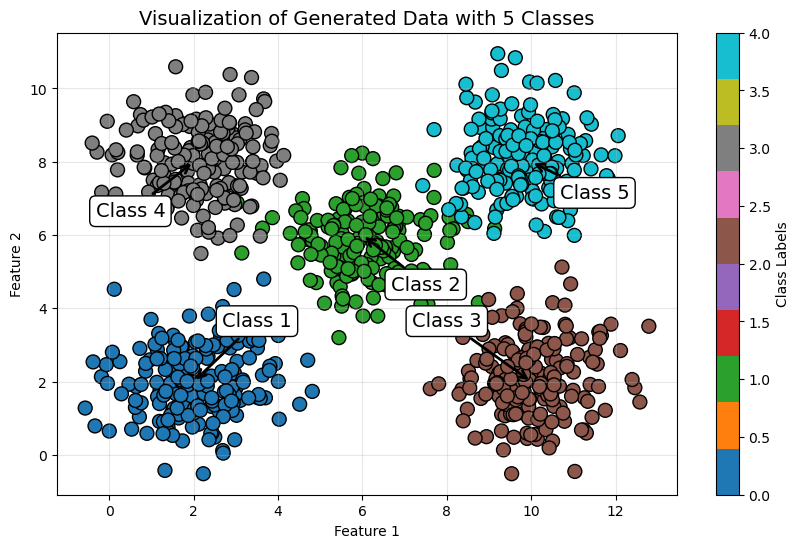

In [7]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="tab10", s=100, edgecolor="k")

centers = [(2, 2), (6, 6), (10, 2), (2, 8), (10, 8)]
offsets = [(1.5, 1.5), (1.5, -1.5), (-2, 1.5), (-1.5, -1.5), (1.5, -1)]

for i, (center, offset) in enumerate(zip(centers, offsets)):
    plt.annotate(f'Class {i + 1}',
                 xy=center,
                 xytext=(center[0] + offset[0], center[1] + offset[1]),
                 arrowprops=dict(facecolor='black', arrowstyle='->', lw=2),
                 fontsize=14,
                 ha="center",
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.title("Visualization of Generated Data with 5 Classes", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(alpha=0.3)
plt.colorbar(scatter, label="Class Labels")
plt.show()

In [9]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=56)

In [13]:
class NeuralNet:
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, lr):
        self.W1 = np.random.randn(input_size, hidden_size1)
        self.W2 = np.random.randn(hidden_size1, hidden_size2)
        self.W3 = np.random.randn(hidden_size2, hidden_size3)
        self.W4 = np.random.randn(hidden_size3, output_size)
        self.lr = lr

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feed_forward(self, x):
        self.hidden_input1 = np.dot(x, self.W1)
        self.hidden_output1 = self.sigmoid(self.hidden_input1)

        self.hidden_input2 = np.dot(self.hidden_output1, self.W2)
        self.hidden_output2 = self.sigmoid(self.hidden_input2)

        self.hidden_input3 = np.dot(self.hidden_output2, self.W3)
        self.hidden_output3 = self.sigmoid(self.hidden_input3)

        self.output_input = np.dot(self.hidden_output3, self.W4)
        self.output = self.softmax(self.output_input)
        return self.output

    def backprop(self, x, y, output):
        output_delta = output - y

        hidden_error3 = np.dot(output_delta, self.W4.T)
        hidden_delta3 = hidden_error3 * self.sigmoid(self.hidden_output3, derivative=True)

        hidden_error2 = np.dot(hidden_delta3, self.W3.T)
        hidden_delta2 = hidden_error2 * self.sigmoid(self.hidden_output2, derivative=True)

        hidden_error1 = np.dot(hidden_delta2, self.W2.T)
        hidden_delta1 = hidden_error1 * self.sigmoid(self.hidden_output1, derivative=True)

        self.W4 -= np.dot(self.hidden_output3.T, output_delta) * self.lr
        self.W3 -= np.dot(self.hidden_output2.T, hidden_delta3) * self.lr
        self.W2 -= np.dot(self.hidden_output1.T, hidden_delta2) * self.lr
        self.W1 -= np.dot(x.T, hidden_delta1) * self.lr

    def train(self, x, y):
        output = self.feed_forward(x)
        self.backprop(x, y, output)

In [15]:
input_size = X_train.shape[1]
hidden_size1 = hidden_size2 = hidden_size3 = 22
output_size = y_train.shape[1]
lr = 0.0015
epochs = 1500

nn = NeuralNet(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, lr)
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    nn.train(X_train, y_train)
    train_output = nn.feed_forward(X_train)
    val_output = nn.feed_forward(X_val)

    train_loss = -np.mean(np.sum(y_train * np.log(train_output + 1e-9), axis=1))
    val_loss = -np.mean(np.sum(y_val * np.log(val_output + 1e-9), axis=1))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_output, axis=1))
    val_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_output, axis=1))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
              f"Train Acc={train_accuracy*100:.2f}%, Val Acc={val_accuracy*100:.2f}%")

Epoch 0: Train Loss=3.9958, Val Loss=3.8644, Train Acc=20.74%, Val Acc=18.89%
Epoch 100: Train Loss=0.4016, Val Loss=0.4410, Train Acc=80.93%, Val Acc=76.67%
Epoch 200: Train Loss=0.3248, Val Loss=0.3893, Train Acc=83.70%, Val Acc=78.33%
Epoch 300: Train Loss=0.3195, Val Loss=0.4005, Train Acc=84.26%, Val Acc=78.33%
Epoch 400: Train Loss=0.2320, Val Loss=0.3059, Train Acc=87.41%, Val Acc=82.22%
Epoch 500: Train Loss=0.3549, Val Loss=0.4283, Train Acc=82.41%, Val Acc=77.78%
Epoch 600: Train Loss=0.3165, Val Loss=0.4016, Train Acc=83.52%, Val Acc=78.33%
Epoch 700: Train Loss=1.1885, Val Loss=1.2445, Train Acc=62.96%, Val Acc=59.44%
Epoch 800: Train Loss=0.3734, Val Loss=0.3967, Train Acc=91.85%, Val Acc=86.67%
Epoch 900: Train Loss=0.4106, Val Loss=0.4319, Train Acc=80.93%, Val Acc=77.22%
Epoch 1000: Train Loss=0.5667, Val Loss=0.5747, Train Acc=71.48%, Val Acc=73.89%
Epoch 1100: Train Loss=0.4343, Val Loss=0.4597, Train Acc=80.37%, Val Acc=76.67%
Epoch 1200: Train Loss=0.3097, Val Loss=

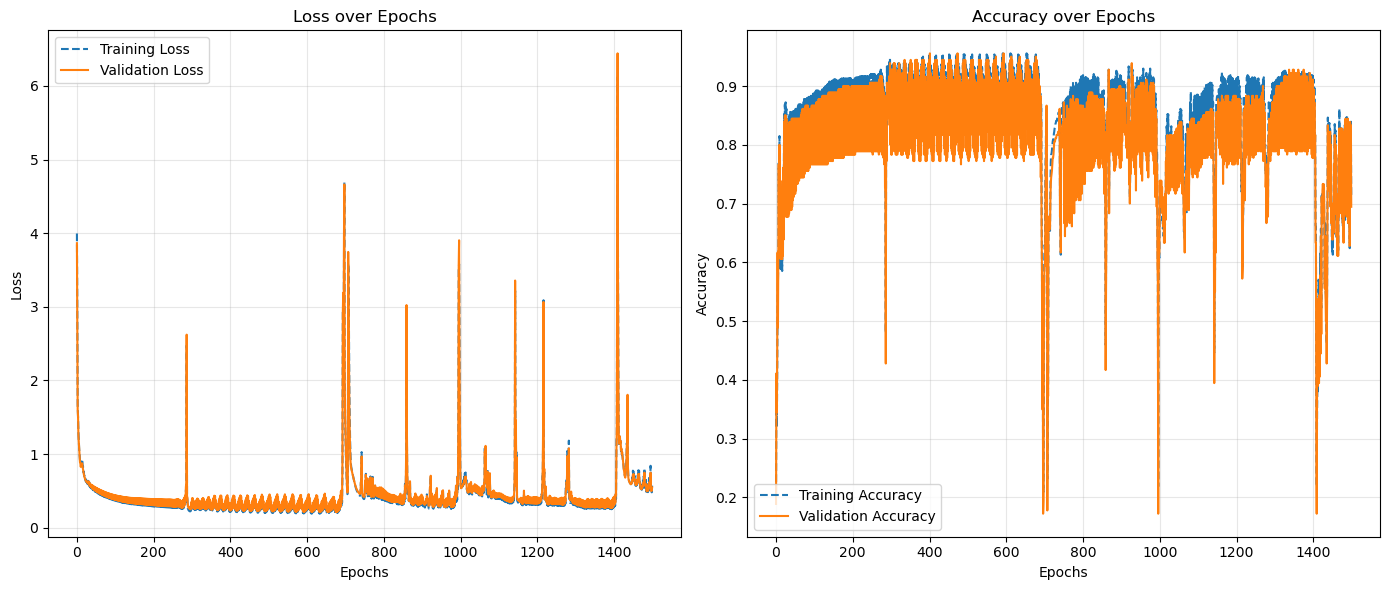

In [17]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", linestyle='--')
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", linestyle='--')
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
test_output = nn.feed_forward(X_test)
predicted_classes = np.argmax(test_output, axis=1)
actual_classes = np.argmax(y_test, axis=1)
test_accuracy = accuracy_score(actual_classes, predicted_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 66.67%


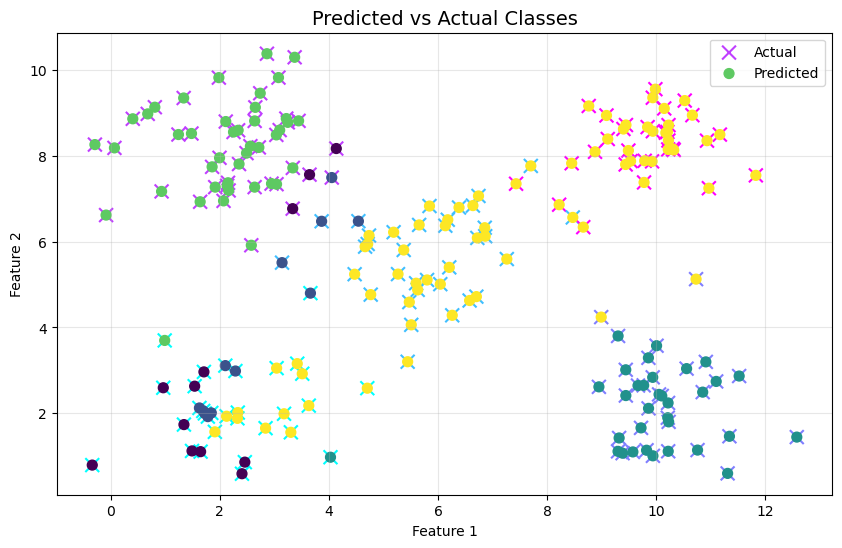

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=actual_classes, cmap='cool', s=100, marker='x', label='Actual')
plt.scatter(X_test[:, 0], X_test[:, 1], c=predicted_classes, cmap='viridis', s=50, marker='o', label='Predicted')
plt.title("Predicted vs Actual Classes", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

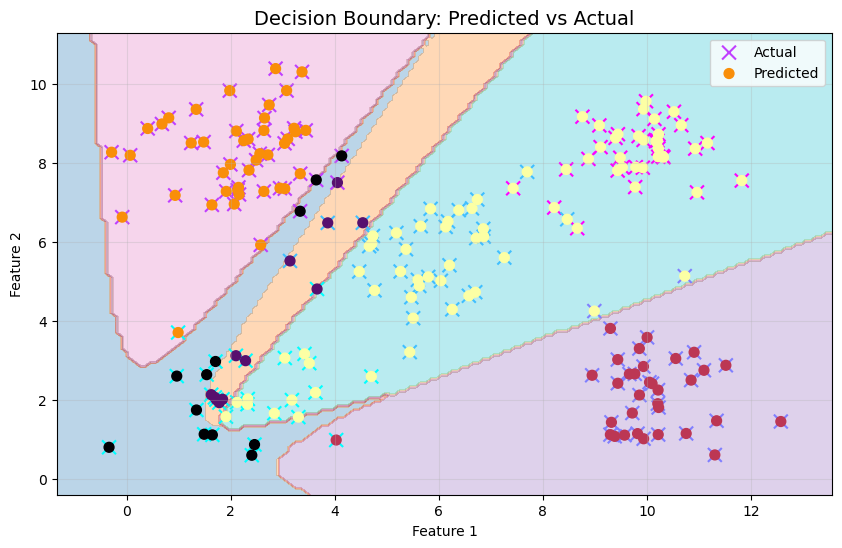

In [23]:
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = np.argmax(nn.feed_forward(np.c_[xx.ravel(), yy.ravel()]), axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab10')
plt.scatter(X_test[:, 0], X_test[:, 1], c=actual_classes, cmap='cool', s=100, marker='x', label='Actual')
plt.scatter(X_test[:, 0], X_test[:, 1], c=predicted_classes, cmap='inferno', s=50, marker='o', label='Predicted')
plt.title("Decision Boundary: Predicted vs Actual", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [25]:
y_true = actual_classes
y_pred = predicted_classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(5)]))


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      0.29      0.42        31
     Class 1       0.25      0.09      0.13        35
     Class 2       0.97      0.94      0.96        34
     Class 3       0.98      0.91      0.94        46
     Class 4       0.42      1.00      0.60        34

    accuracy                           0.67       180
   macro avg       0.67      0.65      0.61       180
weighted avg       0.69      0.67      0.63       180



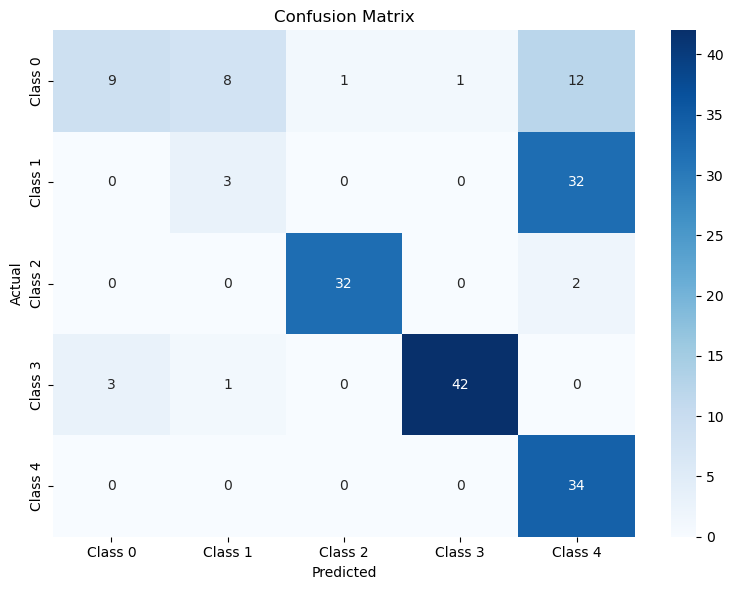

In [27]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, cmap="Blues", fmt="d",
            xticklabels=[f"Class {i}" for i in range(5)],
            yticklabels=[f"Class {i}" for i in range(5)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Discussion:

To handle multi-class classification, the algorithm was updated to create synthetic data with five clear categories using make_classification. The class labels were then one-hot encoded so that the neural network could predict class probabilities using a softmax layer. The model had three hidden layers with ReLU activation functions and used categorical cross-entropy as its loss function. It performed well overall, showing balanced accuracy across the different classes, as confirmed by the confusion matrix and classification report. However, a few misclassifications did occur, likely because of overlapping features or slight imbalances in the class distribution. Some of the main challenges involved finding the right learning rate, properly initializing weights, and making sure the matrix dimensions lined up correctly during backpropagation—especially when dealing with softmax and cross-entropy. Even with synthetic data, it became clear that regularization was important. Going forward, improvements could include adding dropout or L2 regularization, trying different optimizers like Adam or RMSprop, and testing the model on real-world datasets while fine-tuning hyperparameters for better reliability and insight.
